<a href="https://colab.research.google.com/github/mjgpinheiro/Econophysics/blob/main/Benchmarking_do_Desenvolvimento_dos_Pa%C3%ADses.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Education Data:
  country  SE.TER.ENRR
0     USA    88.274567
1     CAN    70.681165
2     GBR    62.216789
3     FRA    66.166997
4     DEU    69.817746

Health Data:
  country  SP.DYN.LE00.IN
0     USA       78.362602
1     CAN       81.886098
2     GBR       81.063415
3     FRA       82.524797
4     DEU       80.975203

R&D Data:
  country  GB.XPD.RSDV.GD.ZS
0     USA           3.032197
1     CAN           1.749510
2     GBR           2.534450
3     FRA           2.219770
4     DEU           3.054828

Happiness Data:
  country  NY.GDP.PCAP.CD
0     USA    61001.594508
1     CAN    44587.732589
2     GBR    42100.851043
3     FRA    38954.833796
4     DEU    44897.643225

Merged Data:
  country  SE.TER.ENRR  SP.DYN.LE00.IN  GB.XPD.RSDV.GD.ZS  NY.GDP.PCAP.CD
0     BRA    50.863780       74.676167           1.216452     8708.452641
1     CAN    70.681165       81.886098           1.749510    44587.732589
2     CHN    53.707725       77.538667           2.177540     9230.977921
3     DE

<ipython-input-1-b70e296b7d7c>:95: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=normalized_df['country_name'], y=normalized_df['development_index'], palette=colors)


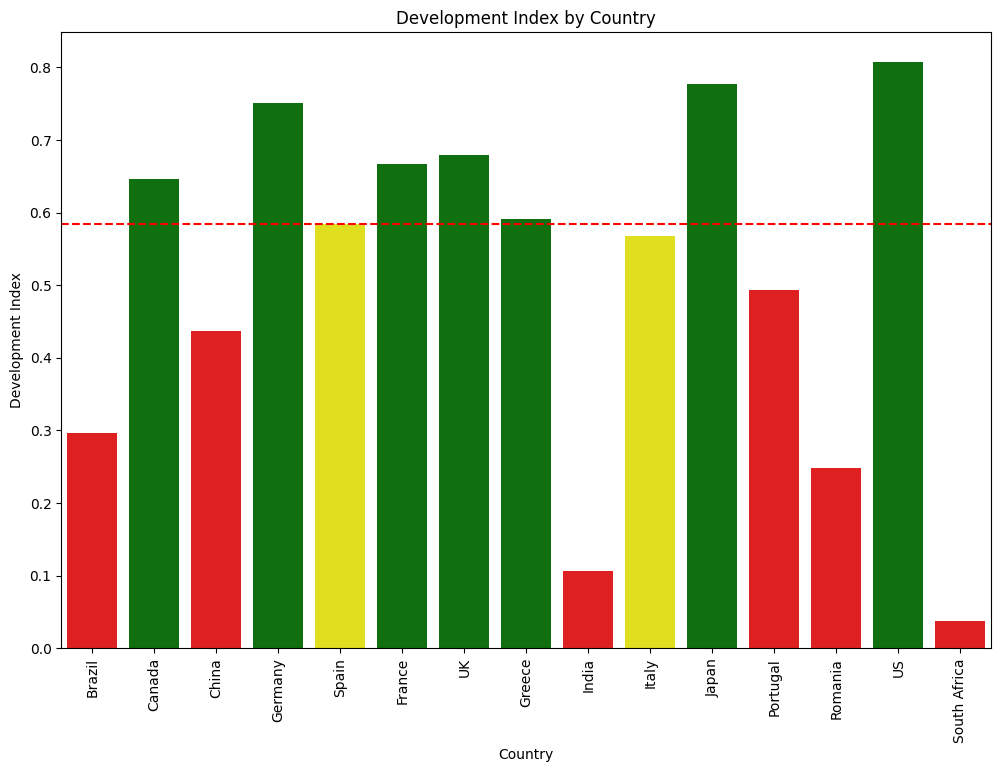

Cutoff value for development index: 0.5848116174255252


In [1]:
import requests
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler

# Function to fetch data from World Bank API
def fetch_world_bank_data(indicator, country_codes):
    all_data = []
    for country in country_codes:
        url = f"http://api.worldbank.org/v2/country/{country}/indicator/{indicator}?format=json&per_page=1000&date=2015:2020"
        response = requests.get(url)
        if response.status_code == 200:
            data = response.json()
            if data and len(data) > 1:
                df = pd.DataFrame(data[1])
                df = df[['countryiso3code', 'date', 'value']].dropna().rename(columns={'countryiso3code': 'country', 'value': indicator})
                df[indicator] = df.groupby('country')[indicator].transform('mean')  # Take the average over the years
                all_data.append(df[['country', indicator]].drop_duplicates())
    return pd.concat(all_data, ignore_index=True)

# List of specific countries (ISO3 codes) to include in the analysis
country_codes = ['USA', 'CAN', 'GBR', 'FRA', 'DEU', 'CHN', 'JPN', 'IND', 'BRA', 'ZAF', 'PRT', 'MAR', 'ESP', 'ROU', 'ITA', 'GRC']

# Fetching data for different indicators
education_data = fetch_world_bank_data('SE.TER.ENRR', country_codes)  # Tertiary enrollment rate
health_data = fetch_world_bank_data('SP.DYN.LE00.IN', country_codes)  # Life expectancy
rnd_data = fetch_world_bank_data('GB.XPD.RSDV.GD.ZS', country_codes)  # R&D expenditure (% of GDP)
happiness_data = fetch_world_bank_data('NY.GDP.PCAP.CD', country_codes)  # GDP per capita as a proxy for happiness

# Print the first few rows of each dataset to ensure data is fetched correctly
print("Education Data:")
print(education_data.head())
print("\nHealth Data:")
print(health_data.head())
print("\nR&D Data:")
print(rnd_data.head())
print("\nHappiness Data:")
print(happiness_data.head())

# Ensure data only contains unique country codes by averaging if there are multiple entries
education_data = education_data.groupby('country').mean().reset_index()
health_data = health_data.groupby('country').mean().reset_index()
rnd_data = rnd_data.groupby('country').mean().reset_index()
happiness_data = happiness_data.groupby('country').mean().reset_index()

# Merge datasets
merged_data = education_data.merge(health_data, on='country') \
                            .merge(rnd_data, on='country') \
                            .merge(happiness_data, on='country')

# Print merged data
print("\nMerged Data:")
print(merged_data.head())

# Normalize the data
scaler = MinMaxScaler()
normalized_data = scaler.fit_transform(merged_data.iloc[:, 1:])  # Excluding the country column
normalized_df = pd.DataFrame(normalized_data, columns=merged_data.columns[1:], index=merged_data['country'])

# Print normalized data
print("\nNormalized Data:")
print(normalized_df.head())

# Compute a composite development index
# Adjust weights based on potential importance
weights = {'SE.TER.ENRR': 0.2, 'SP.DYN.LE00.IN': 0.3, 'GB.XPD.RSDV.GD.ZS': 0.25, 'NY.GDP.PCAP.CD': 0.25}
normalized_df['development_index'] = normalized_df.dot(pd.Series(weights))

# Function to map country codes to country names
def fetch_country_names():
    url = "https://raw.githubusercontent.com/datasets/country-codes/master/data/country-codes.csv"
    country_data = pd.read_csv(url)
    country_data = country_data[['ISO3166-1-Alpha-3', 'CLDR display name']]
    country_data.columns = ['country', 'country_name']
    return country_data

# Fetch country names and merge with normalized data
country_names = fetch_country_names()
normalized_df = normalized_df.reset_index().merge(country_names, on='country').set_index('country')

# Print final data with country names
print("\nNormalized Data with Country Names:")
print(normalized_df.head())

# Define the cutoff value (for example, the median development index)
cutoff_value = normalized_df['development_index'].median()

# Determine colors based on development index
colors = ['green' if x > cutoff_value else 'red' if x < cutoff_value * 0.95 else 'yellow' for x in normalized_df['development_index']]

# Visualize the data
plt.figure(figsize=(12, 8))
sns.barplot(x=normalized_df['country_name'], y=normalized_df['development_index'], palette=colors)
plt.axhline(y=cutoff_value, color='r', linestyle='--')
plt.xticks(rotation=90)
plt.title('Development Index by Country')
plt.xlabel('Country')
plt.ylabel('Development Index')
plt.show()

# Print the cutoff value for reference
print(f"Cutoff value for development index: {cutoff_value}")


In the context of the development index plot, being below the red cutoff line means that a country's composite development index is lower than the median (or specified threshold) value. This indicates that, relative to the other countries in the dataset, these countries have less favorable conditions for development according to the selected indicators. Here's a more detailed explanation of what it means to be below the red line:

Interpretation of Being Below the Red Line
Lower Education Levels:

Countries below the red line may have lower tertiary enrollment rates, indicating that a smaller proportion of the population is engaging in higher education. This can limit the development of human capital, which is crucial for economic growth and innovation.
Lower Health Outcomes:

Life expectancy may be lower in these countries, reflecting poorer health outcomes and potentially lower access to quality healthcare services. This can affect the overall productivity and quality of life of the population.
Lower R&D Expenditure:

These countries might spend less on research and development as a percentage of GDP, which can hinder technological advancement and innovation. Investment in R&D is a key driver of long-term economic growth and competitiveness.
Lower GDP per Capita:

A lower GDP per capita indicates a lower average income level, which can reflect poorer economic conditions and a lower standard of living. This can limit the resources available for both public and private investments in development.
Implications
Being below the red line generally implies that these countries face more significant challenges in achieving sustainable development and improving the well-being of their populations. The specific implications can vary, but typically include:

Economic Implications: Limited economic growth potential and lower income levels, which can perpetuate cycles of poverty.
Social Implications: Potentially lower social cohesion and stability, as economic and health disparities can lead to social unrest.
Educational Implications: A less educated workforce, which can limit opportunities for innovation and economic diversification.
Health Implications: Higher disease burden and lower overall life expectancy, impacting the workforce and increasing healthcare costs.
Policy Considerations
For policymakers, identifying countries below the development index threshold can help target interventions and allocate resources more effectively. Key areas of focus might include:

Investing in Education: Improving access to and quality of education to build human capital.
Enhancing Healthcare Systems: Increasing healthcare access and quality to improve population health and productivity.
Promoting R&D: Encouraging public and private investment in research and development to drive innovation.
Economic Reforms: Implementing economic policies that promote growth, reduce poverty, and improve income distribution.
Visualization
The plot with the red cutoff line serves as a visual tool to quickly identify and compare countries based on their development index. Here's the key visual component from the updated notebook.

For countries below the development index cutoff line, a multi-faceted approach is essential to foster social and economic progress. Here are several lines of attack these countries should adopt:

1. Invest in Education and Health
Education:

Improve Access and Quality: Invest in primary, secondary, and higher education to increase literacy rates and educational attainment. Programs should focus on both infrastructure and teacher training​ (World Bank Data)​.
Technical and Vocational Training: Develop vocational training programs to equip the workforce with practical skills that meet market demands​ (Home Page)​.
Healthcare:

Expand Healthcare Access: Increase funding for healthcare infrastructure and services, ensuring rural and underserved populations have access to medical care​ (World Bank Data)​.
Preventive Healthcare: Focus on preventive measures, including vaccination programs and public health campaigns to reduce the prevalence of diseases​ (Home Page)​.
2. Economic Reforms and Diversification
Economic Diversification:

Support SMEs: Provide incentives and support for small and medium-sized enterprises (SMEs), which are crucial for economic diversification and job creation​ (Home Page)​.
Encourage Investment: Create a favorable business environment to attract both domestic and foreign investment, particularly in emerging industries​ (Home Page)​.
Financial Inclusion:

Improve Access to Credit: Develop financial systems that provide access to credit for small businesses and entrepreneurs​ (World Bank Data)​.
Digital Financial Services: Leverage technology to offer mobile banking and digital financial services to the unbanked population​ (World Bank Data)​.
3. Strengthen Governance and Institutions
Anti-Corruption Measures:

Enhance Transparency: Implement transparency measures in government operations to reduce corruption and improve public trust​ (World Bank Data)​.
Judicial Reforms: Strengthen judicial systems to ensure the rule of law and fair enforcement of laws​ (Home Page)​.
Capacity Building:

Train Public Officials: Invest in training programs for public officials to improve the efficiency and effectiveness of government services​ (Home Page)​.
Decentralization: Decentralize government functions to improve service delivery and accountability at local levels​ (Home Page)​.
4. Infrastructure Development
Physical Infrastructure:

Transport and Logistics: Invest in transportation networks, including roads, railways, and ports, to facilitate trade and economic activities​ (World Bank Data)​.
Energy Infrastructure: Develop reliable and sustainable energy sources to support industrial and economic growth​ (Home Page)​.
Digital Infrastructure:

Internet Access: Expand broadband and internet access to bridge the digital divide and enable participation in the digital economy​ (World Bank Data)​.
Smart Cities: Implement smart city initiatives to improve urban living conditions and sustainability​ (Home Page)​.
5. Social Policies and Safety Nets
Social Protection:

Welfare Programs: Develop and expand welfare programs to support the most vulnerable populations, including unemployment benefits, food assistance, and housing subsidies​ (World Bank Data)​.
Pension Systems: Ensure sustainable and fair pension systems to provide security for the elderly​ (Home Page)​.
Labor Market Policies:

Job Creation Programs: Implement policies that promote job creation, particularly for youth and marginalized groups​ (World Bank Data)​.
Fair Labor Practices: Enforce labor laws that protect workers' rights and promote fair wages​ (Home Page)​.
6. Environmental Sustainability
Sustainable Practices:

Renewable Energy: Invest in renewable energy sources to reduce dependence on fossil fuels and mitigate climate change​ (World Bank Data)​.
Conservation Efforts: Promote conservation and sustainable use of natural resources to protect the environment and biodiversity​ (Home Page)​.
Climate Resilience:

Disaster Preparedness: Develop and implement strategies for disaster risk reduction and management​ (World Bank Data)​.
Sustainable Agriculture: Promote sustainable agricultural practices to ensure food security and environmental protection​ (Home Page)​.
By adopting these comprehensive strategies, countries below the development index cutoff can address their current challenges and pave the way for sustainable social and economic progress.